In [2]:
import sys
sys.path.insert(0, '/workspaces/Hackathon-America')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import warnings
warnings.filterwarnings('ignore')

import src.utils.data_fetcher as datfet

dataFet = datfet.StatsBombDataFetcher()

# Cargar datos de 4 temporadas
seasons = [317, 281, 235, 108]
all_teams = []

for season_id in seasons:
    team_stats = dataFet.get_team_season_stats(competition_id=73, season_id=season_id)
    all_teams.append(team_stats)

df_all_teams = pd.concat(all_teams, ignore_index=True)

print(f"{len(df_all_teams)} registros cargados")
print(f"   Equipos únicos: {df_all_teams['team_name'].nunique()}")
print(f"   Temporadas: {df_all_teams['season_name'].nunique()}")

Usuario configurado: itam_hackathon@hudl.com
Obteniendo estadísticas de equipos (Comp: 73, Temp: 317)...
Estadísticas de 18 equipos obtenidas
Obteniendo estadísticas de equipos (Comp: 73, Temp: 281)...
Estadísticas de 18 equipos obtenidas
Obteniendo estadísticas de equipos (Comp: 73, Temp: 235)...
Estadísticas de 18 equipos obtenidas
Obteniendo estadísticas de equipos (Comp: 73, Temp: 108)...
Estadísticas de 18 equipos obtenidas
72 registros cargados
   Equipos únicos: 18
   Temporadas: 4


In [3]:
numeric_cols = df_all_teams.select_dtypes(include=[np.number]).columns

# Excluir IDs y metadatos
exclude_cols = [
    'account_id', 'team_id', 'competition_id', 'season_id',
    'team_season_matches', 'team_season_minutes'
]

feature_cols = [col for col in numeric_cols if col not in exclude_cols]

print(f"Features para PCA: {len(feature_cols)}")

# Extraer features y limpiar NaNs
X = df_all_teams[feature_cols].fillna(0)

print(f"\nShape de datos: {X.shape}")
print(f"NaNs restantes: {X.isna().sum().sum()}")

Features para PCA: 171

Shape de datos: (72, 171)
NaNs restantes: 0


In [9]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# PCA
pca = PCA(random_state=42)
X_pca = pca.fit_transform(X_scaled)

# Varianza explicada
variance_ratio = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(variance_ratio)

print("VARIANZA EXPLICADA POR COMPONENTE:\n")
for i in range(min(30, len(variance_ratio))):
    print(f"   PC{i+1}: {variance_ratio[i]:.2%} (acumulado: {cumulative_variance[i]:.2%})")

VARIANZA EXPLICADA POR COMPONENTE:

   PC1: 20.06% (acumulado: 20.06%)
   PC2: 9.34% (acumulado: 29.40%)
   PC3: 7.19% (acumulado: 36.59%)
   PC4: 5.94% (acumulado: 42.53%)
   PC5: 5.67% (acumulado: 48.21%)
   PC6: 4.44% (acumulado: 52.64%)
   PC7: 3.93% (acumulado: 56.57%)
   PC8: 3.14% (acumulado: 59.71%)
   PC9: 3.06% (acumulado: 62.77%)
   PC10: 2.84% (acumulado: 65.60%)
   PC11: 2.57% (acumulado: 68.17%)
   PC12: 2.27% (acumulado: 70.44%)
   PC13: 2.09% (acumulado: 72.53%)
   PC14: 1.94% (acumulado: 74.47%)
   PC15: 1.83% (acumulado: 76.30%)
   PC16: 1.68% (acumulado: 77.99%)
   PC17: 1.56% (acumulado: 79.54%)
   PC18: 1.48% (acumulado: 81.03%)
   PC19: 1.37% (acumulado: 82.40%)
   PC20: 1.26% (acumulado: 83.66%)
   PC21: 1.14% (acumulado: 84.81%)
   PC22: 1.03% (acumulado: 85.84%)
   PC23: 0.98% (acumulado: 86.82%)
   PC24: 0.95% (acumulado: 87.77%)
   PC25: 0.85% (acumulado: 88.62%)
   PC26: 0.82% (acumulado: 89.45%)
   PC27: 0.77% (acumulado: 90.21%)
   PC28: 0.70% (acumulado: 

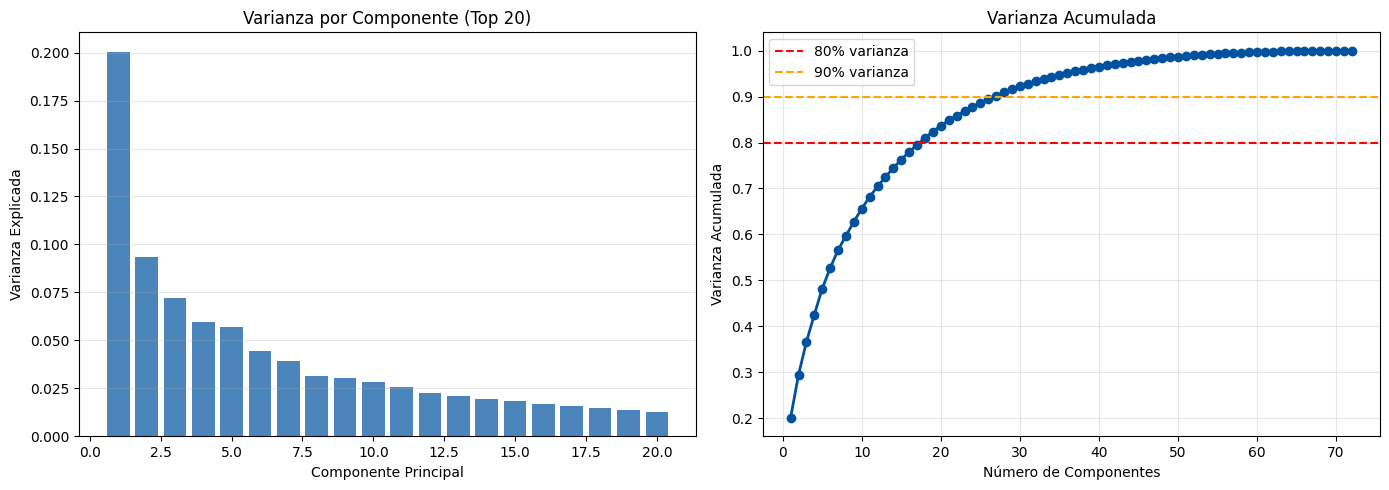


Componentes necesarios:
   80% varianza: 18 componentes
   90% varianza: 27 componentes


In [5]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Gráfica de varianza individual
axes[0].bar(range(1, 21), variance_ratio[:20], color='#00529F', alpha=0.7)
axes[0].set_xlabel('Componente Principal')
axes[0].set_ylabel('Varianza Explicada')
axes[0].set_title('Varianza por Componente (Top 20)')
axes[0].grid(axis='y', alpha=0.3)

# Gráfica de varianza acumulada
axes[1].plot(range(1, len(cumulative_variance)+1), cumulative_variance, 
             marker='o', color='#00529F', linewidth=2)
axes[1].axhline(y=0.80, color='red', linestyle='--', label='80% varianza')
axes[1].axhline(y=0.90, color='orange', linestyle='--', label='90% varianza')
axes[1].set_xlabel('Número de Componentes')
axes[1].set_ylabel('Varianza Acumulada')
axes[1].set_title('Varianza Acumulada')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# ¿Cuántos componentes para 80% y 90%?
n_80 = np.argmax(cumulative_variance >= 0.80) + 1
n_90 = np.argmax(cumulative_variance >= 0.90) + 1

print(f"\nComponentes necesarios:")
print(f"   80% varianza: {n_80} componentes")
print(f"   90% varianza: {n_90} componentes")

In [10]:
n_components = n_90

# Obtener loadings (pesos) de cada feature en cada componente
loadings = pca.components_[:n_components, :]

# Calcular importancia global de cada feature
# (suma de valores absolutos de loadings ponderados por varianza explicada)
feature_importance = np.zeros(len(feature_cols))

for i in range(n_components):
    feature_importance += np.abs(loadings[i, :]) * variance_ratio[i]

# Crear DataFrame de importancia
importance_df = pd.DataFrame({
    'feature': feature_cols,
    'importance': feature_importance
}).sort_values('importance', ascending=False)

print("\nTOP 30 FEATURES MÁS IMPORTANTES:\n")
print(importance_df.head(30).to_string(index=False))


TOP 30 FEATURES MÁS IMPORTANTES:

                                     feature  importance
                        team_season_goals_pg    0.064519
              team_season_xg_per_sp_conceded    0.063202
                  team_season_np_xg_per_shot    0.062815
                           team_season_sp_pg    0.062372
           team_season_corner_xg_conceded_pg    0.062290
                 team_season_obv_conceded_pg    0.061954
          team_season_xg_per_corner_conceded    0.061571
                team_season_np_shot_distance    0.061334
                        team_season_sp_xg_pg    0.061077
               team_season_op_xg_conceded_pg    0.061034
          team_season_sp_shot_ratio_conceded    0.061003
       team_season_np_shot_distance_conceded    0.060957
      team_season_corner_shot_ratio_conceded    0.060689
team_season_op_shots_conceded_outside_box_pg    0.060555
      team_season_counterpressure_regains_pg    0.060196
             team_season_high_press_shots_pg    0.060

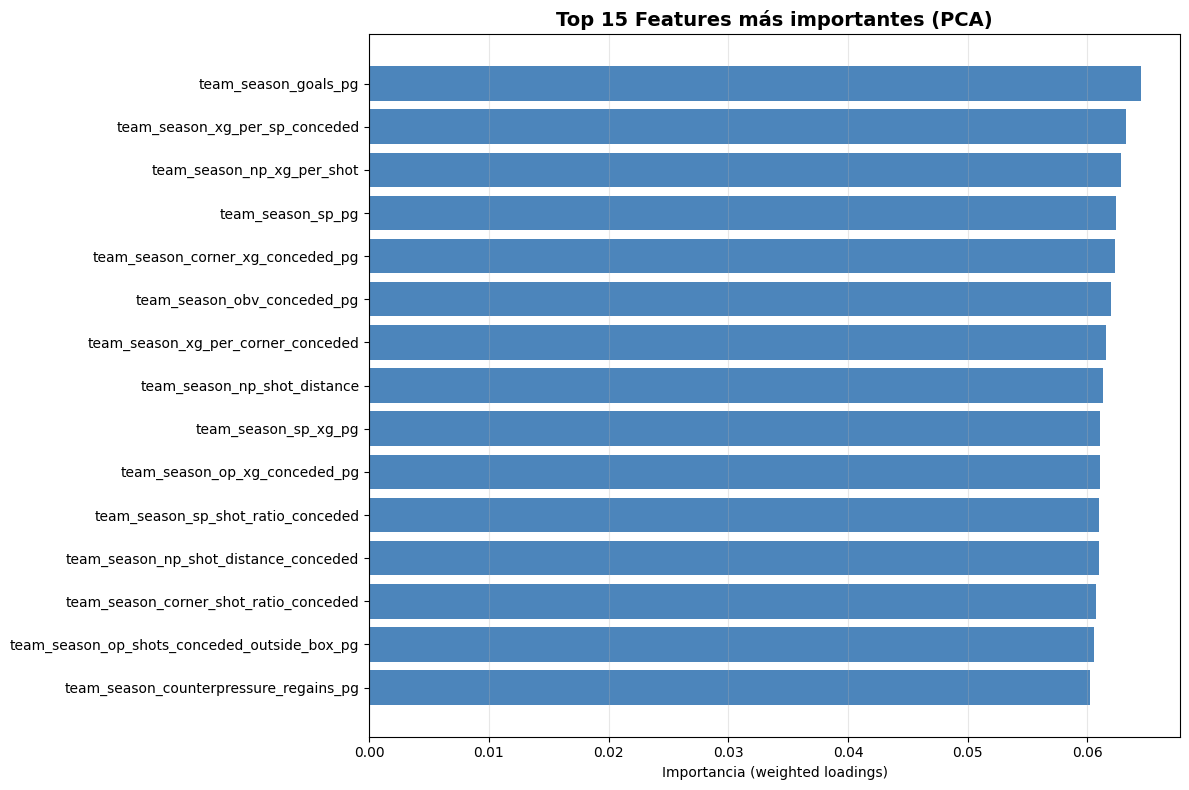

In [7]:
top_n = 15
top_features = importance_df.head(top_n)

plt.figure(figsize=(12, 8))
plt.barh(range(top_n), top_features['importance'].values, color='#00529F', alpha=0.7)
plt.yticks(range(top_n), top_features['feature'].values)
plt.xlabel('Importancia (weighted loadings)')
plt.title(f'Top {top_n} Features más importantes (PCA)', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

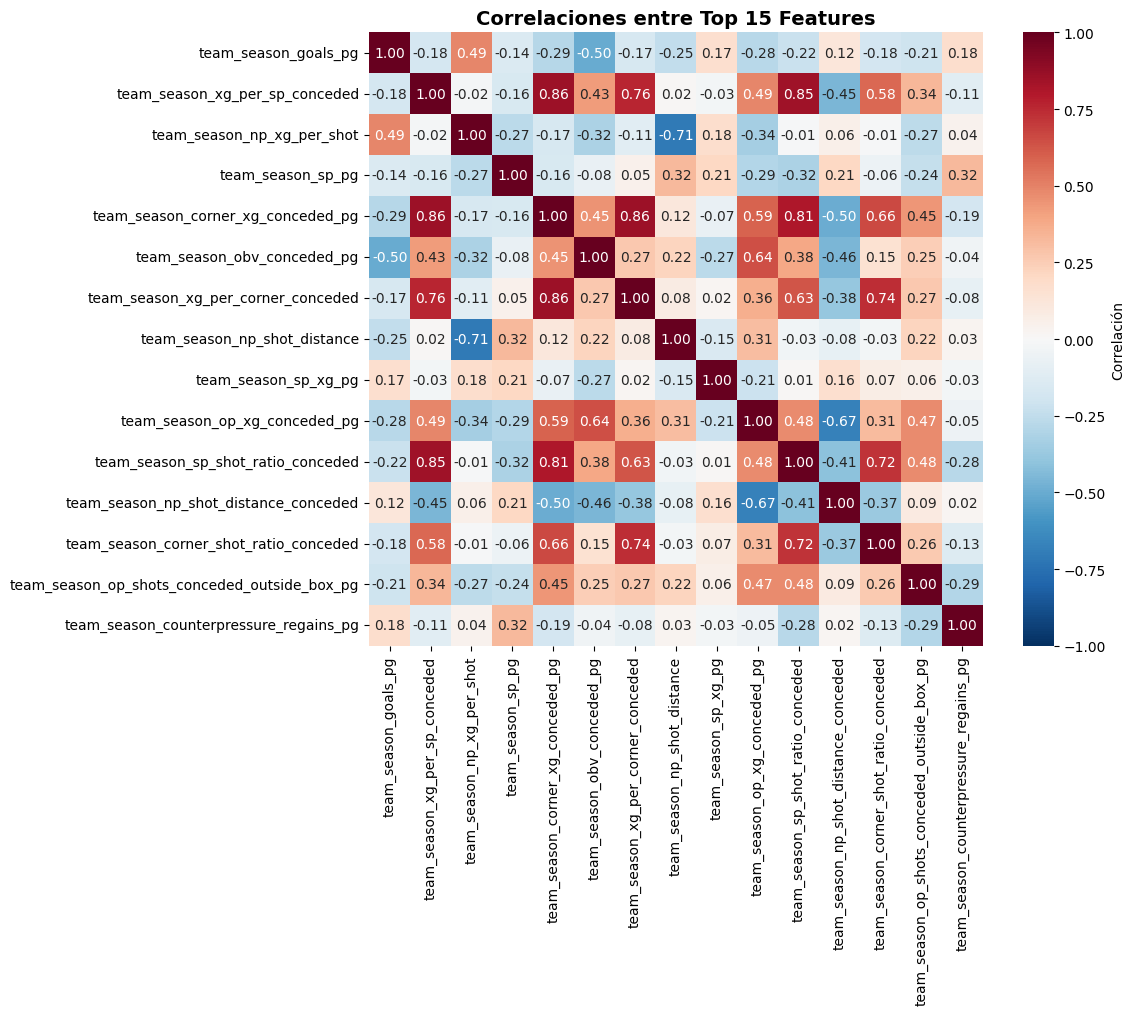

In [8]:
top_feature_names = importance_df.head(15)['feature'].tolist()

# Matriz de correlación
corr_matrix = X[top_feature_names].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(
    corr_matrix,
    annot=True,
    fmt='.2f',
    cmap='RdBu_r',
    center=0,
    vmin=-1,
    vmax=1,
    square=True,
    cbar_kws={'label': 'Correlación'}
)
plt.title('Correlaciones entre Top 15 Features', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()